## Libraries Import

In [7]:
import numpy as np
import pandas as pd
from pymoo.core.sampling import Sampling
from pymoo.core.problem import Problem
from pymoo.visualization.scatter import Scatter
from sklearn.metrics import cohen_kappa_score
import krippendorff
import autograd.numpy as anp
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.factory import get_crossover, get_mutation, get_sampling, get_selection
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter
from pymoo.factory import get_selection
import numpy as np
import numba 
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import Problem


# Functions

## Krippendorff's Alpha

In [8]:
def alpha_disagreement(A,scores):
    
    ni = A.shape[0]
    index = np.argwhere(A == 1)    
    d = {i+1:index[index[:,1]==i] for i in np.unique(index[:,1])}
    for k, v in d.items():
        d[k] = scores[v[:,0]]

    for k, v in d.items():
        d[k] = krippendorff.alpha(reliability_data=v, level_of_measurement="nominal")
    alpha = sum(d.values())
    return alpha

## Requirements

In [9]:
def soft_constraint(A,R,D):
    nj,nk = R.shape
    Ra = np.zeros((nj,nk))
    
    index = np.argwhere(D == 1)
    idi, idj = index.shape
    for k in range(0, idi):
        Ra[index[k,1],:] = A[index[k,0],:] + Ra[index[k,1],:]
        f = np.sum(np.sum(abs(R - Ra)))
    return f

## Group Cohesion

In [10]:
@numba.jit()
def group(A,S,k,ni,nik):

  E = 0
  for i in range(0,ni):
      for j in range(0,ni):
          E = E + A[i,k]*A[j,k]*S[i,j]

  E = E/nik[k]
  return E


def cohesion(A, S, R):
  ni = A.shape[0]
  nk = A.shape[1]
  nik = R.sum(axis=0)
  W = np.zeros((1, nk))
  E = np.zeros((1, nk))
  for k in range(0, nk):
      E[0,k] = group(A,S,k,ni,nik)
      W[0,k] = (np.sum(A[:,k]))/ni
      #print(E[0,k], W[0,k]) 
      
  Ea = W*E
  return Ea.sum()


In [11]:
def requirements(x):
  f=0
  for _x in x:
    A_ = np.reshape(_x,(ni, nik))
    f_aux = soft_constraint(A_,R,D)
    f = f + f_aux
  return 1-f

## Constraints 

In [12]:
def constraints(x, ni, nik):
  v = []
  for _x in x:
    _x = np.reshape(_x, (ni,nik))
    s = np.all(np.sum(_x, axis=1)==1).astype(int)
    v.append((1-s))
  return np.array(v)


In [13]:
def constraints_1(x, R, D):
  v = []
  ni = D.shape[0]
  nik = R.shape[1]
  for _x in x:
    _x = np.reshape(_x, (ni,nik))
    s = soft_constraint(_x, R, D)
    v.append((s))
  return np.array(v)


# Fitness Function

## Multi Objective

In [14]:
def multi_evaluate(x, S, R, D, ni, nik, scores):
  f1 = []
  f2 = []
  for _x in x:
    ni = S.shape[0]
    nik = R.shape[1]
    #convert to matrix
    A_ = np.reshape(_x,(ni, nik))
    f1.append(-1*cohesion(A_, S, R))
    f2.append(alpha_disagreement(A_, scores))
  return f1, f2

# Sampling Operator

In [15]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)


def init_particles(n_pop, ni, nk, n_var):
  
  a = list(range(1,nk+1))
  delta = ni - len(a)
  padded = np.pad(a, (0, delta), 'mean')
  label_encoder.fit(padded)
  pad_ex = label_encoder.transform(padded)
  P = np.random.randint(1, nk+1, size=(n_pop, ni))
  integer_encoded_example = pad_ex.reshape(len(pad_ex), 1)
  onehot_encoder.fit(integer_encoded_example)
  b = []

  for i in range(n_pop): 
    integer_encoded = label_encoder.transform(P[i,:])
    # binary encode
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)
    a = np.array(onehot_encoded)
    a = a.astype(int)
    a = a.flatten()
    b.append(a)

  c = np.vstack(b)
  d = c.reshape((n_pop, n_var))
  pop = d
  return pop

In [16]:
def convert_matrix(ni, nk, n_var, X, R):

  n_pop = X.shape[0]
  a = list(range(1,nk+1))
  delta = ni - len(a)
  padded = np.pad(a, (0, delta), 'mean')
  label_encoder.fit(padded)
  pad_ex = label_encoder.transform(padded)
  integer_encoded_example = pad_ex.reshape(len(pad_ex), 1)
  onehot_encoder.fit(integer_encoded_example)
  b = []
  X = np.round(X)
  for i in range(n_pop):     
    integer_encoded = label_encoder.transform(X[i,:])
    # binary encode
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)
    a = np.array(onehot_encoded)
    a = a.astype(int)
    a = a.flatten()
    b.append(a)

  c = np.vstack(b)
  d = c.reshape((n_pop, n_var*R.shape[1]))
  pop = d
  return pop

In [17]:
def convert_ind(ni, nk, n_var, X, R):

  n_pop = X.shape[0]
  a = list(range(1,nk+1))
  delta = ni - len(a)
  padded = np.pad(a, (0, delta), 'mean')
  label_encoder.fit(padded)
  pad_ex = label_encoder.transform(padded)
  integer_encoded_example = pad_ex.reshape(len(pad_ex), 1)
  onehot_encoder.fit(integer_encoded_example)
  b = []
  #X = np.round(X)
  integer_encoded = label_encoder.transform(X)
   # binary encode
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.transform(integer_encoded)
  a = np.array(onehot_encoded)
  a = a.astype(int)
  a = a.flatten()
  b.append(a)

  c = np.vstack(b)
  d = c.reshape((1, n_var*R.shape[1]))
  pop = d
  return pop

In [18]:
def initial_particles(n_pop, nk, n_var):
    P = np.random.randint(1, nk+1, size=(n_pop, n_var))
    return P

In [19]:
from pymoo.core.sampling import Sampling

class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
      X = initial_particles(n_samples, problem.nik, problem.n_var)
      return X


# Problem Definition in Pymoo

In [20]:
#from pymoo.core.problem import starmap_parallelized_eval


pool = ThreadPool(128)
class Multi_Thread(Problem):

    def __init__(self, S, R, D):

        super().__init__(n_var=S.shape[0], n_obj=2, n_constr=2, xl=1, xu=R.shape[1])

        
        self.S = S
        self.R = R
        self.D = D
        self.ni = self.S.shape[0]
        self.nik = self.R.shape[1]
        np.random.seed(45)
        self.scores = np.random.randint(0,8, (self.ni, 4))


    def _evaluate(self, x, out, *args, **kwargs):
        
        x = convert_matrix(self.ni, self.nik, self.n_var, x, self.R)
        g1 = constraints(x, self.ni, self.nik)
        g2 = constraints_1(x, self.R, self.D) 
        def multi_evaluate(x):
            A_ = np.reshape(x,(self.ni, self.nik))
            f2 = -1*cohesion(A_, self.S, self.R)
            f3 = alpha_disagreement(A_, self.scores)
            return f2, f3

        params = [[x[k]] for k in range(len(x))]
        F = pool.starmap(multi_evaluate, params)
        out["F"] =  np.array(F)
        out["G"] = anp.column_stack([g1, g2])


# Read Benchmark's Dataset

In [21]:
  #A = Alocation vector
  #S = Sociometric matrix
  #R = Requirement matrix
  #ni = number of people to be allocated
  #nik = number of groups
  #D = Departament vector



SocMatrix1 = pd.read_excel('SM1.xlsx', header=None)
ReqMatrix1 = pd.read_excel('RM1.xlsx', header=None)
DepVector1= pd.read_excel('RM1.xlsx', header=None, sheet_name=1)

SM1 = np.array(SocMatrix1)
RM1 = np.array(ReqMatrix1)
D1 = np.array(DepVector1)

SocMatrix2 = pd.read_excel('SM2.xlsx', header=None)
ReqMatrix2 = pd.read_excel('RM2.xlsx', header=None)
DepVector2= pd.read_excel('RM2.xlsx', header=None, sheet_name=1)
SM2 = np.array(SocMatrix2)
RM2 = np.array(ReqMatrix2)
D2 = np.array(DepVector2)

SocMatrix3 = pd.read_excel('SM3.xlsx', header=None)
ReqMatrix3 = pd.read_excel('RM3.xlsx', header=None)
DepVector3= pd.read_excel('RM3.xlsx', header=None, sheet_name=1)

SM3 = np.array(SocMatrix3)
RM3 = np.array(ReqMatrix3)
D3 = np.array(DepVector3)


SocMatrix4 = pd.read_excel('SM4.xlsx', header=None)
ReqMatrix4 = pd.read_excel('RM4.xlsx', header=None)
DepVector4= pd.read_excel('RM4.xlsx', header=None, sheet_name=1)

SM4 = np.array(SocMatrix4)
RM4 = np.array(ReqMatrix4)
D4 = np.array(DepVector4)

SocMatrix5 = pd.read_excel('SM5.xlsx', header=None)
ReqMatrix5 = pd.read_excel('RM5.xlsx', header=None)
DepVector5= pd.read_excel('RM5.xlsx', header=None, sheet_name=1)

SM5 = np.array(SocMatrix5)
RM5 = np.array(ReqMatrix5)
D5 = np.array(DepVector5)

SocMatrix6 = pd.read_excel('SM6.xlsx', header=None)
ReqMatrix6 = pd.read_excel('RM6.xlsx', header=None)
DepVector6= pd.read_excel('RM6.xlsx', header=None, sheet_name=1)

SM6 = np.array(SocMatrix6)
RM6 = np.array(ReqMatrix6)
D6 = np.array(DepVector6)


SocMatrix7 = pd.read_excel('SM7.xlsx', header=None)
ReqMatrix7 = pd.read_excel('RM7.xlsx', header=None)
DepVector7= pd.read_excel('RM7.xlsx', header=None, sheet_name=1)

SM7 = np.array(SocMatrix7)
RM7 = np.array(ReqMatrix7)
D7 = np.array(DepVector7)







#  MOO Running

Here we provide some examples on how to run the algorithms. For the study, we performed 10 simulations rounds for each algorithm in each instance of the problem. The results and its analyses are provided in the next section

In [22]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.operators.survival.rank_and_crowding import RankAndCrowding, ConstrRankAndCrowding
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.indicators.hv import HV


In [25]:
problem1 = Multi_Thread(SM1, RM1, D1)
problem2 = Multi_Thread(SM2, RM2, D2)
problem3 = Multi_Thread(SM3, RM3, D3)
problem4 = Multi_Thread(SM4, RM4, D4)
problem5  = Multi_Thread(SM5, RM5, D5)
problem6  = Multi_Thread(SM6, RM6, D6)
problem7  = Multi_Thread(SM7, RM7, D7)

## NSGA2

In [23]:
algorithm_nsga2 = NSGA2(
      pop_size=80,
      sampling = MySampling(),
      crossover = SBX(prob=0.1),
      mutation = InversionMutation(prob=0.25),
      survival=RankAndCrowding(crowding_func="ce"),
      eliminate_duplicates=True)

An example on how to perform the optmization using the previous defined algorithm

In [27]:
import warnings
warnings.filterwarnings("ignore")

instance = minimize(problem1,
                    algorithm_nsga2,
                    ('n_gen', 500),
                    seed= 1, 
                    verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       80 |      1 |  2.0000000000 |  9.0500000000 |             - |             -
     2 |      160 |      1 |  2.0000000000 |  6.5250000000 |             - |             -
     3 |      240 |      1 |  0.000000E+00 |  4.9000000000 |             - |             -
     4 |      320 |      2 |  0.000000E+00 |  3.7250000000 |  1.0000000000 |         ideal
     5 |      400 |      2 |  0.000000E+00 |  2.9000000000 |  0.000000E+00 |             f
     6 |      480 |      3 |  0.000000E+00 |  2.2750000000 |  0.6666666667 |         ideal
     7 |      560 |      3 |  0.000000E+00 |  1.6000000000 |  0.000000E+00 |             f
     8 |      640 |      4 |  0.000000E+00 |  1.4250000000 |  0.4000000000 |         ideal
     9 |      720 |      4 |  0.000000E+00 |  1.3750000000 |  0.000000E+00 |             f
    10 |      800 |      4 |  0.000000E+00 |  1.2500000000 |  0.000000E+00 |             f

    89 |     7120 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    90 |     7200 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    91 |     7280 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    92 |     7360 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    93 |     7440 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    94 |     7520 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    95 |     7600 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    96 |     7680 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    97 |     7760 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    98 |     7840 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
    99 |     7920 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f

   180 |    14400 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   181 |    14480 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   182 |    14560 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   183 |    14640 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   184 |    14720 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   185 |    14800 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   186 |    14880 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   187 |    14960 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   188 |    15040 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   189 |    15120 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   190 |    15200 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f

   271 |    21680 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   272 |    21760 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   273 |    21840 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   274 |    21920 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   275 |    22000 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   276 |    22080 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   277 |    22160 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   278 |    22240 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   279 |    22320 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   280 |    22400 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   281 |    22480 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f

   362 |    28960 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   363 |    29040 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   364 |    29120 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   365 |    29200 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   366 |    29280 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   367 |    29360 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   368 |    29440 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   369 |    29520 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   370 |    29600 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   371 |    29680 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   372 |    29760 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f

   454 |    36320 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   455 |    36400 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   456 |    36480 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   457 |    36560 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   458 |    36640 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   459 |    36720 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   460 |    36800 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   461 |    36880 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   462 |    36960 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   463 |    37040 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f
   464 |    37120 |      5 |  0.000000E+00 |  1.1000000000 |  0.000000E+00 |             f

## UNSGA 3

In [32]:
ref_dirs = get_reference_directions("energy", 2, 80)
algorithm_unsga3 = UNSGA3(pop_size=80, sampling = MySampling(),
      crossover = SBX(prob=0.1),
      mutation = InversionMutation(prob=0.25),
      ref_dirs = ref_dirs,
      eliminate_duplicates=True)

## SMS-EMOA

In [ ]:
algorithm_sms = SMSEMOA(pop_size=50, sampling = MySampling(),
      crossover = SBX(prob=0.1),
      mutation = InversionMutation(prob=0.25),
      eliminate_duplicates=True)

## SPEA 2

In [47]:
algorithm_spea2 = SPEA2(pop_size=50, sampling = MySampling(),
      crossover = SBX(prob=0.1),
      mutation = InversionMutation(prob=0.25),
      eliminate_duplicates=True)

In [48]:
import warnings
warnings.filterwarnings("ignore")

instance = minimize(problem1,
                    algorithm_spea2,
                    ('n_gen', 500),
                    seed= 1, 
                    verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |  2.0000000000 |  9.0000000000 |             - |             -
     2 |      100 |      1 |  2.0000000000 |  6.7200000000 |             - |             -
     3 |      150 |      1 |  0.000000E+00 |  5.1600000000 |             - |             -
     4 |      200 |      1 |  0.000000E+00 |  3.9600000000 |  0.3000000000 |         ideal
     5 |      250 |      1 |  0.000000E+00 |  2.8400000000 |  0.000000E+00 |             f
     6 |      300 |      1 |  0.000000E+00 |  2.3600000000 |  0.000000E+00 |             f
     7 |      350 |      2 |  0.000000E+00 |  1.6800000000 |  1.0000000000 |         ideal
     8 |      400 |      3 |  0.000000E+00 |  1.6000000000 |  0.4707543730 |         ideal
     9 |      450 |      2 |  0.000000E+00 |  1.4400000000 |  0.3094387330 |         ideal
    10 |      500 |      2 |  0.000000E+00 |  1.2800000000 |  0.000000E+00 |             f

    89 |     4450 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    90 |     4500 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    91 |     4550 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    92 |     4600 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    93 |     4650 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    94 |     4700 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    95 |     4750 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    96 |     4800 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    97 |     4850 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    98 |     4900 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
    99 |     4950 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f

   180 |     9000 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   181 |     9050 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   182 |     9100 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   183 |     9150 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   184 |     9200 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   185 |     9250 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   186 |     9300 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   187 |     9350 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   188 |     9400 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   189 |     9450 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   190 |     9500 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f

   271 |    13550 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   272 |    13600 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   273 |    13650 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   274 |    13700 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   275 |    13750 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   276 |    13800 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   277 |    13850 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   278 |    13900 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   279 |    13950 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   280 |    14000 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   281 |    14050 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f

   362 |    18100 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   363 |    18150 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   364 |    18200 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   365 |    18250 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   366 |    18300 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   367 |    18350 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   368 |    18400 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   369 |    18450 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   370 |    18500 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   371 |    18550 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   372 |    18600 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f

   453 |    22650 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   454 |    22700 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   455 |    22750 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   456 |    22800 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   457 |    22850 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   458 |    22900 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   459 |    22950 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   460 |    23000 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   461 |    23050 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   462 |    23100 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f
   463 |    23150 |      5 |  0.000000E+00 |  0.5600000000 |  0.000000E+00 |             f

# Results

In [30]:
@numba.jit()
def find_non_dominated_points(data):
    """
    Returns the set of non-dominated points in a two-dimensional array
    considering maximization of two objectives.

    Parameters:
        data (ndarray): A 2-dimensional array of shape (n, 2) containing the data
                        points to be evaluated.

    Returns:
        non_dominated (ndarray): A 2-dimensional array containing the non-dominated
                                 points with duplicates removed.
    """
    non_dominated = []

    for i in range(data.shape[0]):
        is_dominated = False

        for j in range(data.shape[0]):
            if i == j:
                continue

            if (data[i][0] < data[j][0] and data[i][1] < data[j][1]):
                is_dominated = True
                break

        if not is_dominated:
            non_dominated.append(data[i])

    non_dominated = np.array(non_dominated)
    non_dominated = np.unique(non_dominated, axis=0)

    return non_dominated

## Pareto plots

For the first four instances of the problem all the algorithms were able to find the same solution. However to instances 5,6 and 7, we can observe some differences. In this section we visualize the results and its respective Pareto fronts 

In [34]:
nsga2_5_cd = pd.read_csv(r'\simulacoes\nsga2\cd\pareto_nsga2_cd_5.csv', header=None)
nsga2_5_cd = find_non_dominated_points(nsga2_5_cd.values)
nsga2_5_ce = pd.read_csv(r'\simulacoes\nsga2\ce\pareto_nsga2_ce_5.csv', header=None)
nsga2_5_ce = find_non_dominated_points(nsga2_5_ce.values)
nsga2_5_pcd = pd.read_csv(r'\simulacoes\nsga2\pcd\pareto_nsga2_pcd_5.csv', header=None)
nsga2_5_pcd = find_non_dominated_points(nsga2_5_pcd.values)
unsga3_5 = pd.read_csv(r'\simulacoes\unsga3\pareto_unsga3_5.csv', header=None)
unsga3_5 = find_non_dominated_points(unsga3_5.values)
sms_5 = pd.read_csv(r'\simulacoes\sms\pareto_sms_5.csv', header=None)
sms_5 = find_non_dominated_points(sms_5.values)
spea_5 = pd.read_csv(r'\simulacoes\spea2\pareto_spea2_5.csv', header=None)
spea_5 = find_non_dominated_points(spea_5.values)

nsga2_6_cd = pd.read_csv(r'\simulacoes\nsga2\cd\pareto_nsga2_cd_6.csv', header=None)
nsga2_6_cd = find_non_dominated_points(nsga2_6_cd.values)
nsga2_6_pcd = pd.read_csv(r'\simulacoes\nsga2\pcd\pareto_nsga2_pcd_6.csv', header=None)
nsga2_6_pcd = find_non_dominated_points(nsga2_6_pcd.values)
nsga2_6_ce = pd.read_csv(r'\simulacoes\nsga2\ce\pareto_nsga2_ce_6.csv', header=None)
nsga2_6_ce = find_non_dominated_points(nsga2_6_ce.values)
unsga3_6 = pd.read_csv(r'\simulacoes\unsga3\pareto_unsga3_6.csv', header=None)
unsga3_6 = find_non_dominated_points(unsga3_6.values)
sms_6 = pd.read_csv(r'\simulacoes\sms\pareto_sms_6.csv', header=None)
sms_6 = find_non_dominated_points(sms_6.values)
spea_6 = pd.read_csv(r'\simulacoes\spea2\pareto_spea2_6.csv', header=None)
spea_6 = find_non_dominated_points(spea_6.values)

nsga2_7_cd = pd.read_csv(r'\simulacoes\nsga2\cd\pareto_nsga2_cd_7.csv', header=None)
nsga2_7_cd = find_non_dominated_points(nsga2_7_cd.values)
nsga2_7_pcd = pd.read_csv(r'\simulacoes\nsga2\pcd\pareto_nsga2_pcd_7.csv', header=None)
nsga2_7_pcd = find_non_dominated_points(nsga2_7_pcd.values)
nsga2_7_ce = pd.read_csv(r'\simulacoes\nsga2\ce\pareto_nsga2_ce_7.csv', header=None)
nsga2_7_ce = find_non_dominated_points(nsga2_7_ce.values)
unsga3_7 = pd.read_csv(r'\simulacoes\unsga3\pareto_unsga3_7.csv', header=None)
unsga3_7 = find_non_dominated_points(unsga3_7.values)
sms_7 = pd.read_csv(r'\simulacoes\sms\pareto_sms_7.csv', header=None)
sms_7 = find_non_dominated_points(sms_7.values)
spea_7 = pd.read_csv(r'\simulacoes\spea2\pareto_spea2_7.csv', header=None)
spea_7 = find_non_dominated_points(spea_7.values)



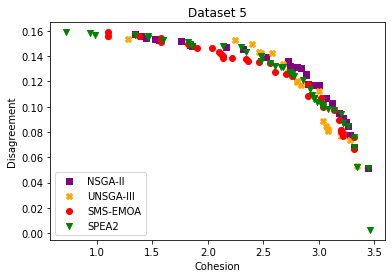

In [35]:
plt.scatter(nsga2_5_ce[:,0], nsga2_5_ce[:,1], marker='s', label='NSGA-II', c='purple')
plt.scatter(unsga3_5[:,0], unsga3_5[:,1], marker='X', label= 'UNSGA-III', c='orange')
plt.scatter(sms_5[:,0], sms_5[:,1], marker='o', label='SMS-EMOA', c='red')
plt.scatter(spea_5[:,0], spea_5[:,1], marker='v', label='SPEA2', c='green')


plt.title('Dataset 5') 
plt.xlabel('Cohesion')
plt.ylabel('Disagreement')
plt.legend(loc='best')


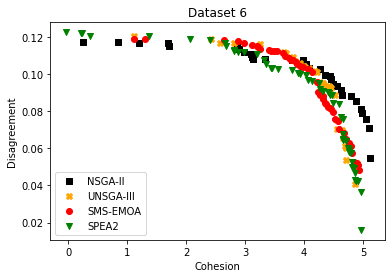

In [36]:
plt.scatter(nsga2_6_pcd[:,0], nsga2_6_pcd[:,1], marker='s', label='NSGA-II', c='black')
plt.scatter(unsga3_6[:,0], unsga3_6[:,1], marker='X', label= 'UNSGA-III', c='orange')
plt.scatter(sms_6[:,0], sms_6[:,1], marker='o', label='SMS-EMOA', c='red')
plt.scatter(spea_6[:,0], spea_6[:,1], marker='v', label='SPEA2', c='green')


plt.title('Dataset 6') #adicionando o título
plt.xlabel('Cohesion')
plt.ylabel('Disagreement')
plt.legend(loc='best')


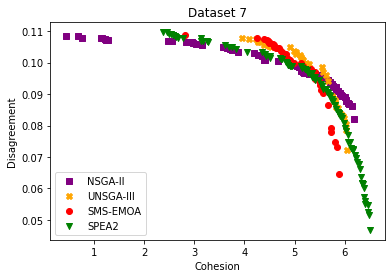

In [37]:
plt.scatter(nsga2_7_ce[:,0], nsga2_7_ce[:,1], marker='s', label='NSGA-II', c='purple')
plt.scatter(unsga3_7[:,0], unsga3_7[:,1], marker='X', label= 'UNSGA-III', c='orange')
plt.scatter(sms_7[:,0], sms_7[:,1], marker='o', label='SMS-EMOA', c='red')
plt.scatter(spea_7[:,0], spea_7[:,1], marker='v', label='SPEA2', c='green')


plt.title('Dataset 7') #adicionando o título
plt.xlabel('Cohesion')
plt.ylabel('Disagreement')
plt.legend(loc='best')

## Pareto quality assessment - Hypervolume

The hypervolume calculation is a way to express the quality of a Pareto set in a quantitative measure. Then, the boxplot for the hypervolume computation is displayed

In [38]:
hv_nsga2_1_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_1.csv', header=None)
hv_nsga2_1_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_1.csv', header=None)
hv_nsga2_1_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_1.csv', header=None)
hv_unsga3_1 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_1.csv', header=None)
hv_sms_1 = pd.read_csv(r'simulacoes\sms\hv_sms_1.csv', header=None)
hv_spea_1 = pd.read_csv(r'simulacoes\spea2\hv_spea2_1.csv', header=None)


hv_nsga2_2_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_2.csv', header=None)
hv_nsga2_2_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_2.csv', header=None)
hv_nsga2_2_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_2.csv', header=None)
hv_unsga3_2 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_2.csv', header=None)
hv_sms_2 = pd.read_csv(r'simulacoes\sms\hv_sms_2.csv', header=None)
hv_spea_2 = pd.read_csv(r'simulacoes\spea2\hv_spea2_2.csv', header=None)

hv_nsga2_3_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_3.csv', header=None)
hv_nsga2_3_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_3.csv', header=None)
hv_nsga2_3_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_3.csv', header=None)
hv_unsga3_3 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_3.csv', header=None)
hv_sms_3 = pd.read_csv(r'simulacoes\sms\hv_sms_3.csv', header=None)
hv_spea_3 = pd.read_csv(r'simulacoes\spea2\hv_spea2_3.csv', header=None)

hv_nsga2_4_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_4.csv', header=None)
hv_nsga2_4_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_4.csv', header=None)
hv_nsga2_4_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_4.csv', header=None)
hv_unsga3_4 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_4.csv', header=None)
hv_sms_4 = pd.read_csv(r'simulacoes\sms\hv_sms_4.csv', header=None)
hv_spea_4 = pd.read_csv(r'simulacoes\spea2\hv_spea2_4.csv', header=None)


hv_nsga2_5_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_5.csv', header=None)
hv_nsga2_5_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_5.csv', header=None)
hv_nsga2_5_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_5.csv', header=None)
hv_unsga3_5 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_5.csv', header=None)
hv_sms_5 = pd.read_csv(r'simulacoes\sms\hv_sms_5.csv', header=None)
hv_spea_5 = pd.read_csv(r'simulacoes\spea2\hv_spea2_5.csv', header=None)

hv_nsga2_6_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_6.csv', header=None)
hv_nsga2_6_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_6.csv', header=None)
hv_nsga2_6_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_6.csv', header=None)
hv_unsga3_6 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_6.csv', header=None)
hv_sms_6 = pd.read_csv(r'simulacoes\sms\hv_sms_6.csv', header=None)
hv_spea_6 = pd.read_csv(r'simulacoes\spea2\hv_spea2_6.csv', header=None)

hv_nsga2_7_cd = pd.read_csv(r'simulacoes\nsga2\cd\hv_nsga2_cd_7.csv', header=None)
hv_nsga2_7_pcd = pd.read_csv(r'simulacoes\nsga2\pcd\hv_nsga2_pcd_7.csv', header=None)
hv_nsga2_7_ce = pd.read_csv(r'simulacoes\nsga2\ce\hv_nsga2_ce_7.csv', header=None)
hv_unsga3_7 = pd.read_csv(r'simulacoes\unsga3\hv_unsga3_7.csv', header=None)
hv_sms_7 = pd.read_csv(r'simulacoes\sms\hv_sms_7.csv', header=None)
hv_spea_7 = pd.read_csv(r'simulacoes\spea2\hv_spea2_7.csv', header=None)



In [39]:
hv_spea_5['Alg'] = "SPEA2"
hv_nsga2_5_cd['Alg'] = "NSGA-II"
hv_unsga3_5['Alg'] = "U-NSGA-III"
hv_sms_5['Alg'] = "SMS-EMOA"
hv_nsga2_5_pcd['Alg'] = "NSGA-II"
hv_nsga2_5_ce['Alg'] = "NSGA-II"

hv_spea_6['Alg'] = "SPEA2"
hv_nsga2_6_cd['Alg'] = "NSGA-II"
hv_unsga3_6['Alg'] = "U-NSGA-III"
hv_sms_6['Alg'] = "SMS-EMOA"
hv_nsga2_6_pcd['Alg'] = "NSGA-II"
hv_nsga2_6_ce['Alg'] = "NSGA-II"

hv_spea_7['Alg'] = "SPEA2"
hv_nsga2_7_cd['Alg'] = "NSGA-II"
hv_unsga3_7['Alg'] = "U-NSGA-III"
hv_sms_7['Alg'] = "SMS-EMOA"
hv_nsga2_7_pcd['Alg'] = "NSGA-II"
hv_nsga2_7_ce['Alg'] = "NSGA-II"

In [40]:
algos = [hv_spea_5, hv_unsga3_5, hv_sms_5, hv_nsga2_5_ce]
algos6 = [hv_spea_6, hv_unsga3_6, hv_sms_6, hv_nsga2_6_pcd]
algos7 = [hv_spea_7, hv_unsga3_7, hv_sms_7, hv_nsga2_7_ce]

hv_5 = pd.concat(algos)
hv_6 = pd.concat(algos6)
hv_7 = pd.concat(algos7)

hv_5['Algorithm'] = hv_5['Alg']
hv_6['Algorithm'] = hv_6['Alg']
hv_7['Algorithm'] = hv_7['Alg']

<Figure size 1000x1000 with 0 Axes>

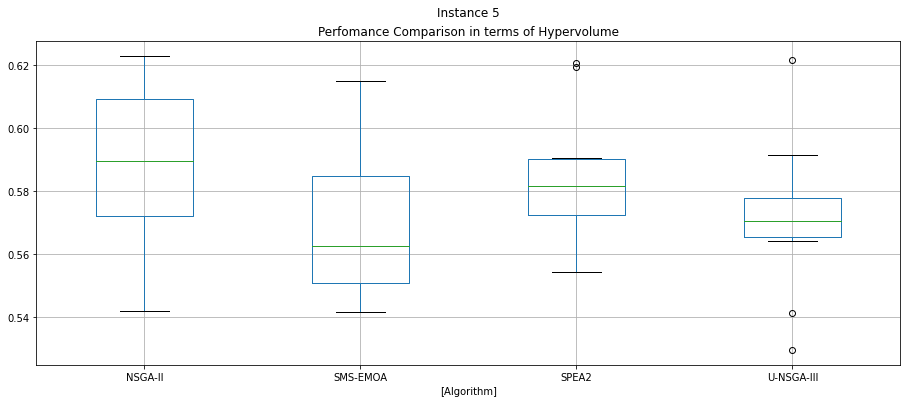

In [41]:
plt.figure(figsize=(5, 5), dpi=200)
hv_5.boxplot(by="Algorithm", figsize=(15, 6))
plt.title('Perfomance Comparison in terms of Hypervolume')
plt.suptitle('Instance 5')


Text(0.5, 0.98, 'Instance 6')

<Figure size 1000x1000 with 0 Axes>

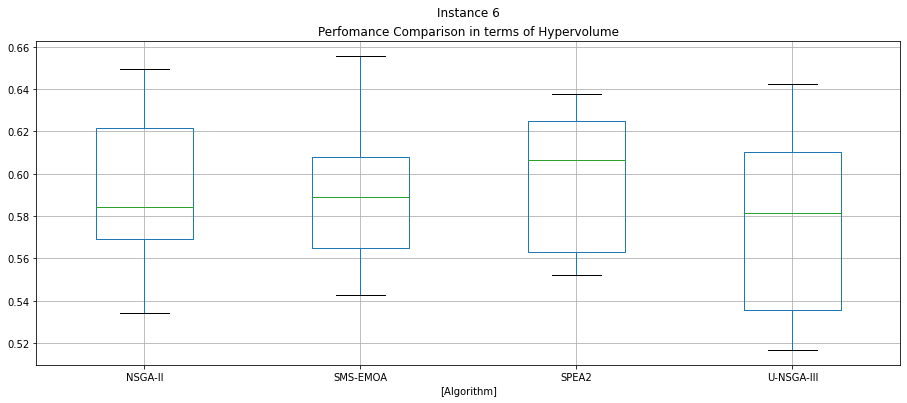

In [42]:
plt.figure(figsize=(5, 5), dpi=200)
hv_6.boxplot(by="Algorithm", figsize=(15, 6))
plt.title('Perfomance Comparison in terms of Hypervolume') #adicionando o título
plt.suptitle('Instance 6')


<Figure size 1000x1000 with 0 Axes>

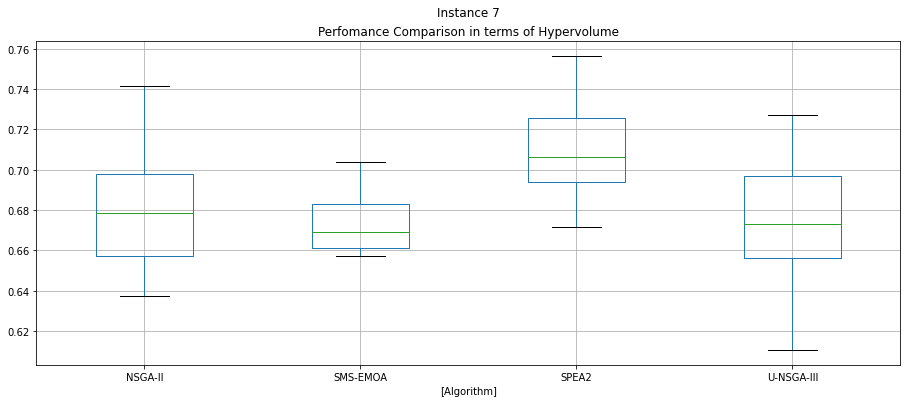

In [43]:
plt.figure(figsize=(5, 5), dpi=200)
hv_7.boxplot(by="Algorithm", figsize=(15, 6))
plt.title('Perfomance Comparison in terms of Hypervolume') #adicionando o título
plt.suptitle('Instance 7')
plt.savefig('boxplot7.png')

# Grid Search

In [ ]:
from pymoo.factory import get_performance_indicator

time: 1.61 ms (started: 2022-03-19 19:56:23 +00:00)


In [43]:
problem = Multi_Thread(SM5, RM5, D5)

mutation_rates = {'1':(1/problem.ni),'2':0.01, '3':0.05, '4':0.1,'5':0.25}

h = []
for i in range(1,10,1):
  for value in mutation_rates.values():
    
    algorithm = NSGA2(
          pop_size=80,
          sampling = MySampling(),
          crossover = SBX(prob=(i/10)),
          mutation = InversionMutation(prob=value),
          eliminate_duplicates=True)

    import warnings
    warnings.filterwarnings("ignore")

    res1 = minimize(problem,
                    algorithm,
                    ('n_gen', 3500),
                    verbose=False)
    hv = HV(ref_point=np.array([1, 0]))
    hyper = hv(res1.F)
    lista = [hyper, i/10, value]
    h.append(lista)
    print("hv = ", hyper, "crossover = ", i/10, "mutation = ", value)
H = pd.DataFrame.from_records(h)

hv =  0.483484641877609 crossover =  0.1 mutation =  0.02
hv =  0.4292305765189418 crossover =  0.1 mutation =  0.01
hv =  0.5372785224630015 crossover =  0.1 mutation =  0.05
hv =  0.4709842106999046 crossover =  0.1 mutation =  0.1
hv =  0.6053121799039577 crossover =  0.1 mutation =  0.25
hv =  0.3553157498301341 crossover =  0.3 mutation =  0.02
hv =  0.26325879871397995 crossover =  0.3 mutation =  0.01
hv =  0.4659791750179884 crossover =  0.3 mutation =  0.05
hv =  0.5307460576150769 crossover =  0.3 mutation =  0.1
hv =  0.5595680718847322 crossover =  0.3 mutation =  0.25
hv =  0.3087933325446436 crossover =  0.5 mutation =  0.02
hv =  0.26944436467846117 crossover =  0.5 mutation =  0.01
hv =  0.42511409957600066 crossover =  0.5 mutation =  0.05
hv =  0.5087951730277882 crossover =  0.5 mutation =  0.1
hv =  0.5626153856223111 crossover =  0.5 mutation =  0.25
hv =  0.17638676596866643 crossover =  0.7 mutation =  0.02
hv =  0.23083760429211692 crossover =  0.7 mutation =  0

In [ ]:
# hv =  0.28728293451009734 crossover =  0.2 mutation =  0.02
# hv =  0.28690046830932747 crossover =  0.2 mutation =  0.01
# hv =  0.24522132716134604 crossover =  0.2 mutation =  0.05
# hv =  0.2719269236436319 crossover =  0.2 mutation =  0.1
# hv =  0.2864929819627692 crossover =  0.2 mutation =  0.25
# hv =  0.26916070320222674 crossover =  0.4 mutation =  0.02
# hv =  0.18159348097430023 crossover =  0.4 mutation =  0.01
# hv =  0.2935262171061318 crossover =  0.4 mutation =  0.05
# hv =  0.27949825122045735 crossover =  0.4 mutation =  0.1
# hv =  0.28315341602090893 crossover =  0.4 mutation =  0.25
# hv =  0.2258603114075607 crossover =  0.6 mutation =  0.02
# hv =  0.17251932215781773 crossover =  0.6 mutation =  0.01
# hv =  0.23350519584747953 crossover =  0.6 mutation =  0.05
# hv =  0.2466161151328397 crossover =  0.6 mutation =  0.1
# hv =  0.25082311738780094 crossover =  0.6 mutation =  0.25
# hv =  0.22536100565876965 crossover =  0.8 mutation =  0.02
# hv =  0.15778690176002194 crossover =  0.8 mutation =  0.01
# hv =  0.23926376921237147 crossover =  0.8 mutation =  0.05
# hv =  0.23630979924816414 crossover =  0.8 mutation =  0.1
# hv =  0.26681335121709815 crossover =  0.8 mutation =  0.25